In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import process_data

In [2]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import process_data

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)
print(parent_dir)
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_with_overtime")
features = ["game_completed", "relative_strength", "score_difference", "type.id", "home_has_possession", "end.down", "end.yardsToEndzone", "end.distance", "field_position_shift", "home_timeouts_left", "away_timeouts_left"]

/Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML


In [4]:
interpolated_dir = os.path.join(parent_dir, "dataset_interpolated_with_overtime")
training_data = process_data.load_data(interpolated_dir, 
                                       years = [2018, 2019, 2020, 2021, 2022], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

validation_data = process_data.load_data(interpolated_dir, 
                                       years = [2023], 
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

test_data = process_data.load_data(interpolated_dir, 
                                       years = [2024],
                                       history_length = 0, 
                                       features = features, 
                                       label_feature = "home_win")

Loading data for 2022
Loading data for 2024
skipping  2024
Loading data for 2023
skipping  2023
Loading data for 2015
skipping  2015
Loading data for .DS_Store
Loading data for 2017
skipping  2017
Loading data for 2019
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2019/game_401127989.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2019/game_401127963.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2019/game_401127963.csv
Loading data for 2021
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/code/evalRTPF/R/NFL/ML/dataset_interpolated_with_overtime/2021/game_401326405.csv
  NaN found in file: /Users/aly/Documents/University_of_Waterloo/Winter 2025/Research/c

In [25]:
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

def _sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

def brier_loss(y_true, y_pred):
    return np.mean((y_pred - y_true)**2)

def brier_objective(preds, train_data):
    """Custom Brier score objective function for LightGBM."""
    labels = train_data.get_label()
    # Transform raw predictions to probabilities using sigmoid
    probs = _sigmoid(preds)
    # Gradient: derivative of Brier score w.r.t. raw predictions
    grad = 2.0 * (probs - labels) * probs * (1.0 - probs)
    # Hessian: second derivative of Brier score w.r.t. raw predictions
    hess = 2.0 * probs * (1.0 - probs) * (1.0 - 2.0 * probs * (probs - labels))
    return grad, hess

def brier_eval(preds, train_data):
    """Custom Brier score evaluation metric for LightGBM."""
    labels = train_data.get_label()
    probs = _sigmoid(preds)
    brier = np.mean((probs - labels)**2)
    return 'brier', brier, False  # eval_name, eval_result, is_higher_better

class LightGBM:
    def __init__(self, use_calibration=True, **kwargs):
        # Heavily regularized parameters to prevent overfitting
        self.params = {
            'boosting_type': 'gbdt',
            'objective': brier_objective,
            'metric': 'None',
            'num_leaves': 15,  # Reduced complexity
            'max_depth': 4,    # Reduced depth
            'learning_rate': 0.03,  # Slower learning
            'feature_fraction': 0.7,  # More feature subsampling
            'bagging_fraction': 0.7,  # More row subsampling  
            'bagging_freq': 5,
            'reg_alpha': 1.0,  # Strong L1 regularization
            'reg_lambda': 1.0, # Strong L2 regularization
            'min_data_in_leaf': 50,  # Larger leaf size
            'min_gain_to_split': 0.5,  # Stricter splitting
            'max_bin': 255,
            'verbose': -1,
            'random_state': 42,
            'force_col_wise': True
        }
        self.params.update(kwargs)
        
        self.num_boost_round = 1000
        self.model = None
        self.calibrator = None
        self.use_calibration = use_calibration
        self.feature_names = None

    def fit(self, X, y, val_X=None, val_y=None):
        # Use provided validation or create internal split
        if val_X is None and val_y is None:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=0.25, random_state=42, stratify=y
            )
        else:
            X_train, y_train = X, y
            X_val, y_val = val_X, val_y
        
        # Create datasets
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        
        # Enhanced early stopping
        callbacks = [
            log_evaluation(period=0),
            early_stopping(stopping_rounds=15, verbose=False)  # More aggressive early stopping
        ]
        
        # Train with strict early stopping
        self.model = lgb.train(
            self.params,
            train_data,
            num_boost_round=self.num_boost_round,
            feval=brier_eval,
            valid_sets=[val_data],  # Only monitor validation set
            callbacks=callbacks
        )
        
        # Store feature info
        if hasattr(X, 'shape'):
            self.feature_names = [f'feature_{i}' for i in range(X.shape[1])]
        
        # Calibration using validation data only
        if self.use_calibration:
            raw_preds_cal = self.model.predict(X_val, num_iteration=self.model.best_iteration)
            uncalibrated_probs_cal = _sigmoid(raw_preds_cal)
            
            self.calibrator = IsotonicRegression(out_of_bounds='clip')
            self.calibrator.fit(uncalibrated_probs_cal, y_val)

    def predict(self, X):
        """Return binary predictions (0 or 1)."""
        if self.model is None:
            raise ValueError("Model must be fitted before making predictions")
        
        # Get probabilities and convert to binary predictions
        probs = self.predict_proba(X)[:, 1]
        return (probs > 0.5).astype(int)

    def predict_proba(self, X):
        """Return prediction probabilities."""
        if self.model is None:
            raise ValueError("Model must be fitted before making predictions")
        
        # Get raw predictions and convert to probabilities
        raw_preds = self.model.predict(X, num_iteration=self.model.best_iteration)
        uncalibrated_probs = _sigmoid(raw_preds)
        
        # Apply calibration if available
        if self.use_calibration and self.calibrator is not None:
            calibrated_probs = self.calibrator.predict(uncalibrated_probs)
            # Ensure probabilities are in valid range
            calibrated_probs = np.clip(calibrated_probs, 0.0, 1.0)
            return np.column_stack([1 - calibrated_probs, calibrated_probs])
        else:
            # Return uncalibrated probabilities
            return np.column_stack([1 - uncalibrated_probs, uncalibrated_probs])

    def score(self, X, y):
        """Return accuracy score."""
        predictions = self.predict(X)
        return np.mean(predictions == y)



In [6]:
training_data.keys()

dict_keys([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.075, 0.08, 0.085, 0.09, 0.095, 0.1, 0.105, 0.11, 0.115, 0.12, 0.125, 0.13, 0.135, 0.14, 0.145, 0.15, 0.155, 0.16, 0.165, 0.17, 0.175, 0.18, 0.185, 0.19, 0.195, 0.2, 0.205, 0.21, 0.215, 0.22, 0.225, 0.23, 0.235, 0.24, 0.245, 0.25, 0.255, 0.26, 0.265, 0.27, 0.275, 0.28, 0.285, 0.29, 0.295, 0.3, 0.305, 0.31, 0.315, 0.32, 0.325, 0.33, 0.335, 0.34, 0.345, 0.35, 0.355, 0.36, 0.365, 0.37, 0.375, 0.38, 0.385, 0.39, 0.395, 0.4, 0.405, 0.41, 0.415, 0.42, 0.425, 0.43, 0.435, 0.44, 0.445, 0.45, 0.455, 0.46, 0.465, 0.47, 0.475, 0.48, 0.485, 0.49, 0.495, 0.5, 0.505, 0.51, 0.515, 0.52, 0.525, 0.53, 0.535, 0.54, 0.545, 0.55, 0.555, 0.56, 0.565, 0.57, 0.575, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.61, 0.615, 0.62, 0.625, 0.63, 0.635, 0.64, 0.645, 0.65, 0.655, 0.66, 0.665, 0.67, 0.675, 0.68, 0.685, 0.69, 0.695, 0.7, 0.705, 0.71, 0.715, 0.72, 0.725, 0.73, 0.735, 0.74, 0.745, 0.75, 0.755, 0.76, 0.7

=== Understanding Isotonic Regression Calibration ===


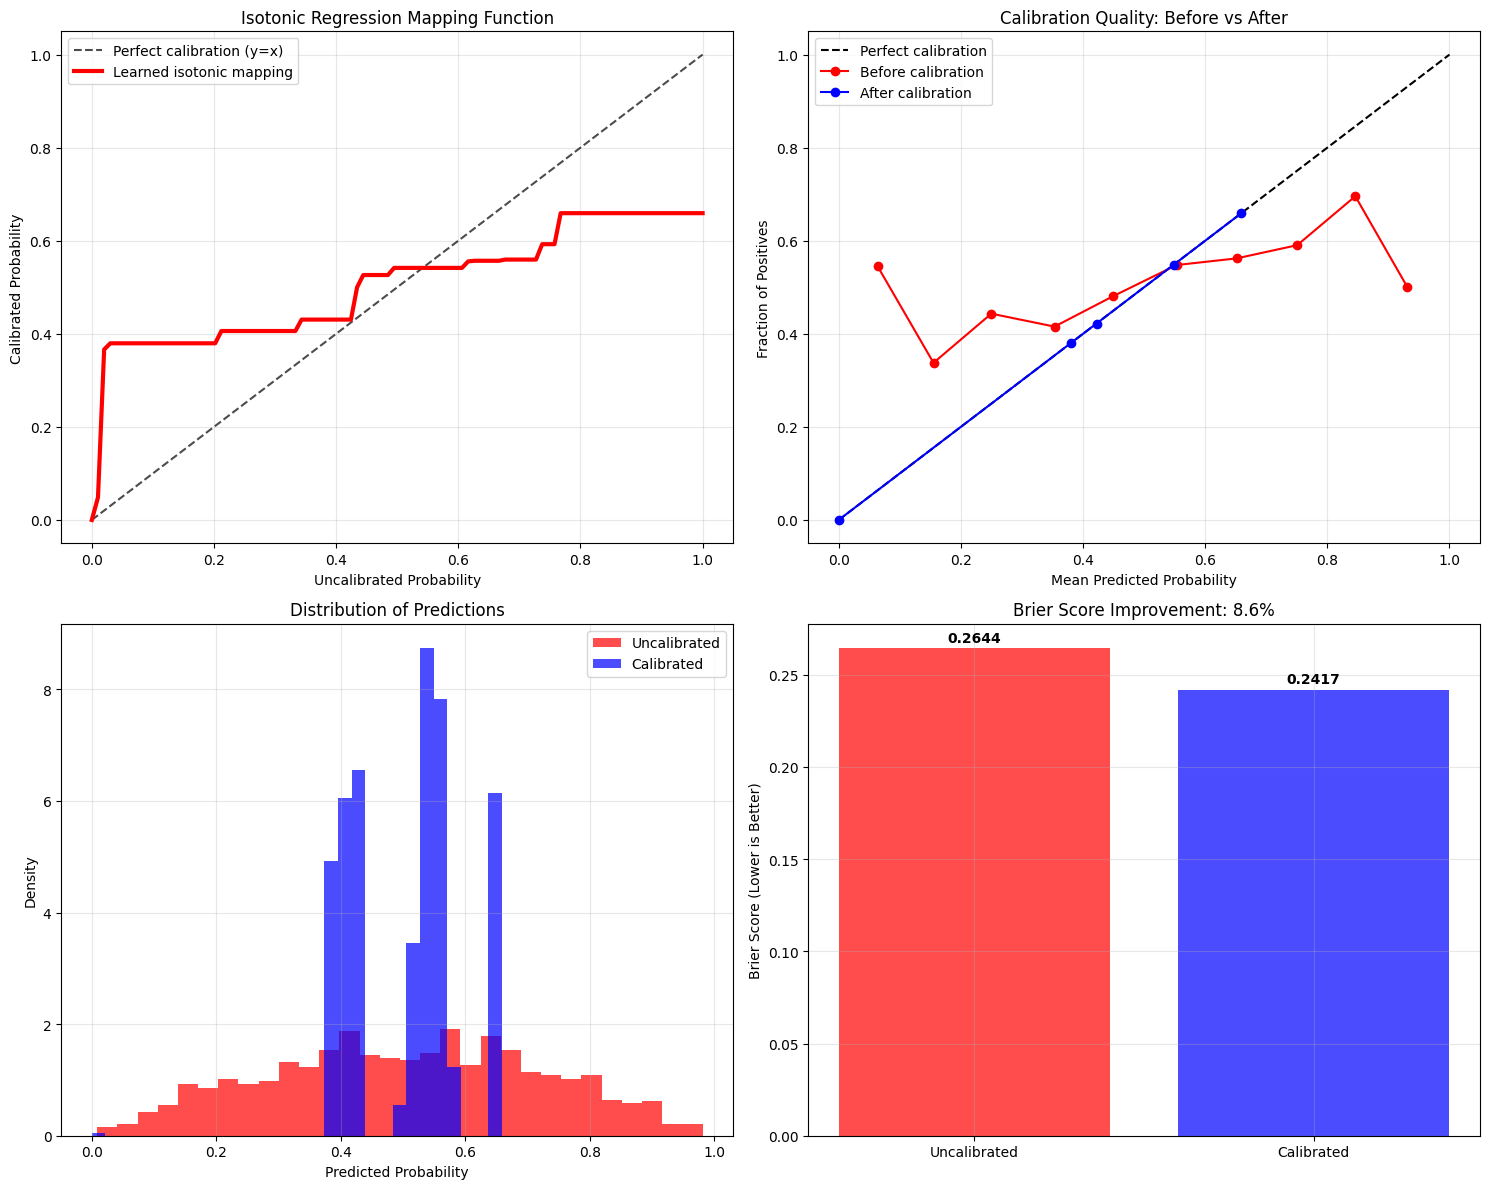


Example Results:
Uncalibrated Brier Score: 0.2644
Calibrated Brier Score: 0.2417
Improvement: 8.6%


=== Comparing Calibrated vs Uncalibrated LightGBM ===

Testing at timestep 50.0%
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	train's brier: 0.180945	valid's brier: 0.185597
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[500]	train's brier: 0.180945	valid's brier: 0.185597
Uncalibrated - Accuracy: 0.7485, Brier Score: 0.1975
Calibrated   - Accuracy: 0.7279, Brier Score: 0.1764
Improvement in Brier Score: 10.7%


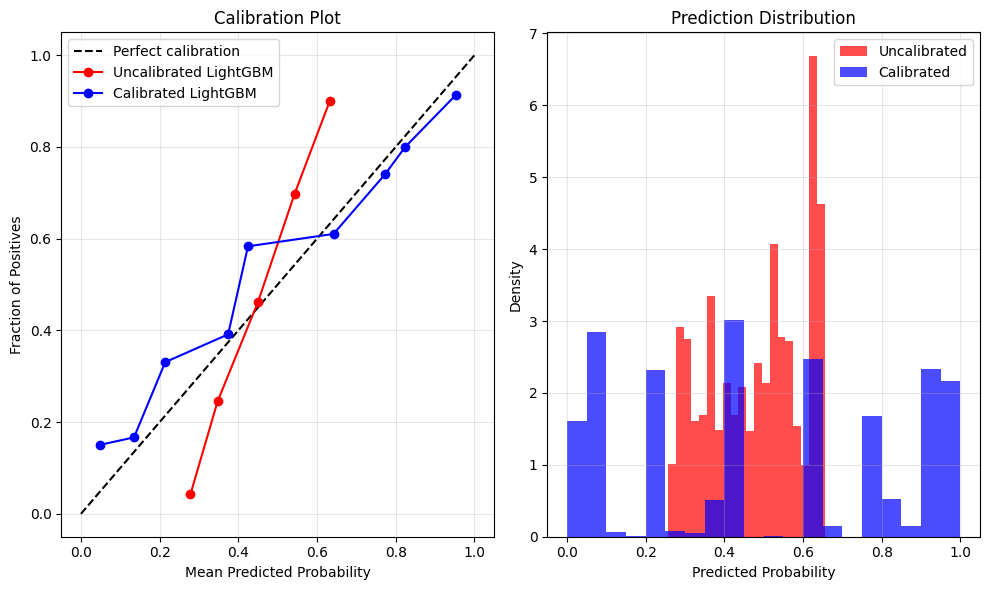

In [31]:
def setup_models(training_data, validation_data):
    models = {}
    timesteps = list(training_data.keys())
    
    for i, timestep in enumerate(timesteps):
        timestep = round(timestep, 3)
        
        # Prepare data
        X = training_data[timestep]
        y = np.array([row["label"] for row in X])
        X = np.array([row["rows"].reshape(-1) for row in X])
        y_val = np.array([row["label"] for row in validation_data[timestep]])
        X_val = np.array([row["rows"].reshape(-1) for row in validation_data[timestep]])
        
        # Train model with enhanced regularization
        model = LightGBM(use_calibration=False)
        model.fit(X, y, val_X=X_val, val_y=y_val)
         # Calculate training loss
        y_pred = model.predict_proba(X)[:, 1]  # Get probability predictions
        train_loss = brier_loss(y, y_pred)
        train_accuracy = model.score(X, y)

        y_val_pred = model.predict_proba(X_val)[:, 1]
        val_loss = brier_loss(y_val, y_val_pred)  # Use Brier score to match objective function
        val_accuracy = model.score(X_val, y_val)
        print(f"Timestep {timestep:.2%}: Training Loss = {train_loss:.4f}, Accuracy = {train_accuracy:.4f}, Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}")
        models[timestep] = model
        
        # Progress indicator (minimal output)
        if (i + 1) % 10 == 0 or i == len(timesteps) - 1:
            print(f"Completed {i + 1}/{len(timesteps)} timesteps")
    
    return models


models = setup_models(training_data, validation_data)

Timestep 0.00%: Training Loss = 0.2175, Accuracy = 0.6502, Validation Loss = 0.2293, Validation Accuracy = 0.6013
Timestep 0.50%: Training Loss = 0.2169, Accuracy = 0.6492, Validation Loss = 0.2325, Validation Accuracy = 0.5724
Timestep 1.00%: Training Loss = 0.2209, Accuracy = 0.6451, Validation Loss = 0.2352, Validation Accuracy = 0.5795
Timestep 1.50%: Training Loss = 0.2191, Accuracy = 0.6513, Validation Loss = 0.2326, Validation Accuracy = 0.6025
Timestep 2.00%: Training Loss = 0.2194, Accuracy = 0.6539, Validation Loss = 0.2335, Validation Accuracy = 0.5767
Timestep 2.50%: Training Loss = 0.2207, Accuracy = 0.6577, Validation Loss = 0.2353, Validation Accuracy = 0.5741
Timestep 3.00%: Training Loss = 0.2140, Accuracy = 0.6624, Validation Loss = 0.2282, Validation Accuracy = 0.6204
Timestep 3.50%: Training Loss = 0.2191, Accuracy = 0.6499, Validation Loss = 0.2354, Validation Accuracy = 0.5673
Timestep 4.00%: Training Loss = 0.2174, Accuracy = 0.6619, Validation Loss = 0.2395, Val

In [ ]:
def setup_single_model(training_data, test_data):
    # Flatten all training data into single arrays
    X_train = []
    y_train = []
    for timestep in training_data:
        for row in training_data[timestep]:
            X_train.append(row["rows"].reshape(-1))
            y_train.append(row["label"])
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Flatten all test data into single arrays  
    X_test = []
    y_test = []
    for timestep in test_data:
        for row in test_data[timestep]:
            X_test.append(row["rows"].reshape(-1))
            y_test.append(row["label"])
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # Train with enhanced regularization
    model = LightGBM(use_calibration=True)
    model.fit(X_train, y_train)

    # Evaluate performance
    y_test_pred = model.predict_proba(X_test)[:, 1]
    test_loss = brier_loss(y_test, y_test_pred)
    test_accuracy = model.score(X_test, y_test)

    print(f"Test Loss = {test_loss:.4f}, Test Accuracy = {test_accuracy:.4f}")

    return model

# model = setup_single_model(training_data, test_data)

0:	total: 27ms	remaining: 8.07s
1:	total: 50ms	remaining: 7.45s
2:	total: 69.5ms	remaining: 6.88s
3:	total: 90.9ms	remaining: 6.73s
4:	total: 110ms	remaining: 6.51s
5:	total: 133ms	remaining: 6.5s
6:	total: 153ms	remaining: 6.42s
7:	total: 174ms	remaining: 6.36s
8:	total: 194ms	remaining: 6.28s
9:	total: 214ms	remaining: 6.21s
10:	total: 234ms	remaining: 6.15s
11:	total: 257ms	remaining: 6.16s
12:	total: 277ms	remaining: 6.12s
13:	total: 298ms	remaining: 6.08s
14:	total: 321ms	remaining: 6.09s
15:	total: 341ms	remaining: 6.05s
16:	total: 361ms	remaining: 6s
17:	total: 380ms	remaining: 5.96s
18:	total: 399ms	remaining: 5.9s
19:	total: 418ms	remaining: 5.85s
20:	total: 437ms	remaining: 5.81s
21:	total: 458ms	remaining: 5.78s
22:	total: 481ms	remaining: 5.8s
23:	total: 501ms	remaining: 5.76s
24:	total: 521ms	remaining: 5.73s
25:	total: 542ms	remaining: 5.71s
26:	total: 563ms	remaining: 5.69s
27:	total: 583ms	remaining: 5.66s
28:	total: 602ms	remaining: 5.63s
29:	total: 621ms	remaining: 5.

Timestep 0.00%: Accuracy = 0.6829, Brier Score = 0.2256
Timestep 0.50%: Accuracy = 0.6820, Brier Score = 0.2224
Timestep 1.00%: Accuracy = 0.6584, Brier Score = 0.2280
Timestep 1.50%: Accuracy = 0.6634, Brier Score = 0.2283
Timestep 2.00%: Accuracy = 0.6771, Brier Score = 0.2232
Timestep 2.50%: Accuracy = 0.6984, Brier Score = 0.2217
Timestep 3.00%: Accuracy = 0.6820, Brier Score = 0.2216
Timestep 3.50%: Accuracy = 0.6667, Brier Score = 0.2304
Timestep 4.00%: Accuracy = 0.6726, Brier Score = 0.2254
Timestep 4.50%: Accuracy = 0.6817, Brier Score = 0.2209
Timestep 5.00%: Accuracy = 0.7045, Brier Score = 0.2173
Timestep 5.50%: Accuracy = 0.6813, Brier Score = 0.2290
Timestep 6.00%: Accuracy = 0.6607, Brier Score = 0.2285
Timestep 6.50%: Accuracy = 0.6707, Brier Score = 0.2325
Timestep 7.00%: Accuracy = 0.6450, Brier Score = 0.2341
Timestep 7.50%: Accuracy = 0.7018, Brier Score = 0.2179
Timestep 8.00%: Accuracy = 0.6930, Brier Score = 0.2217
Timestep 8.50%: Accuracy = 0.7216, Brier Score =

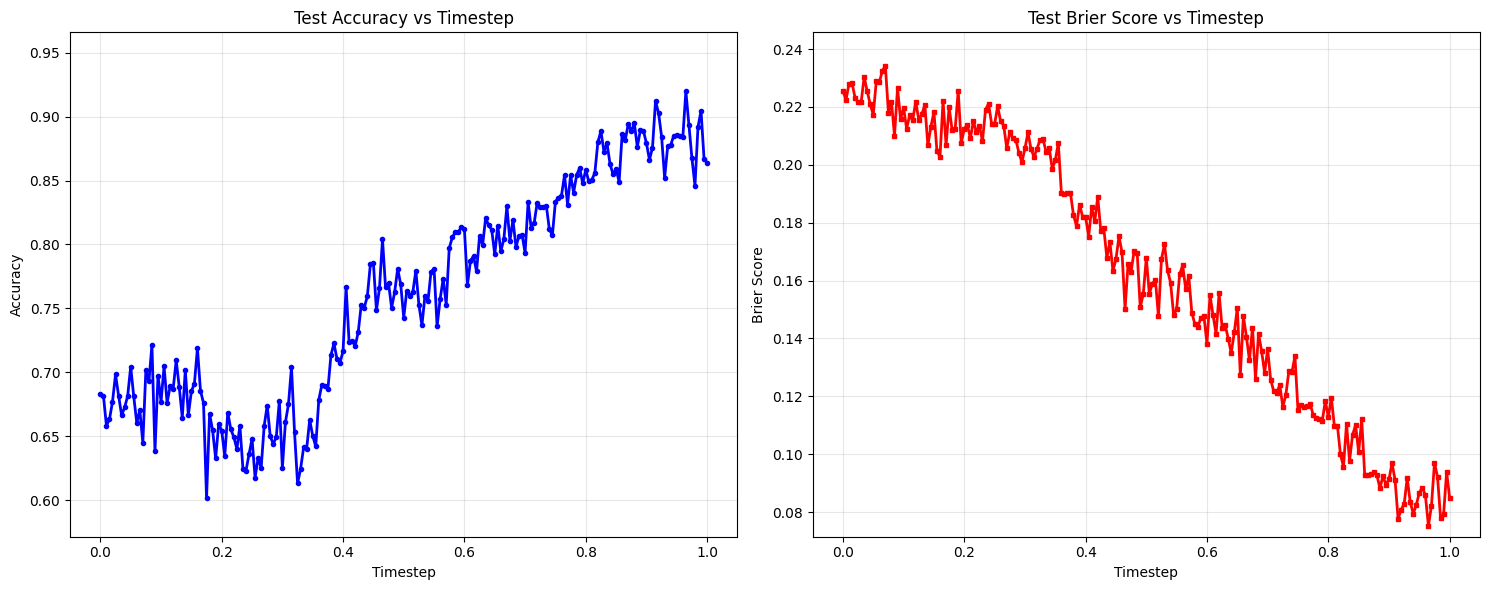


Summary Statistics:
Average Accuracy: 0.7597 ± 0.0863
Average Brier Score: 0.1620 ± 0.0480
Best Accuracy: 0.9198 at timestep 96.50%
Best Brier Score: 0.0753 at timestep 96.50%


In [32]:
# Test accuracy and Brier score of model for each timestep on test data and plot
accuracies = []
brier_scores = []
timesteps = []

for timestep, i in zip(models, test_data.keys()):
    model = models[timestep]
    # Convert test data to array
    y_test = np.array([row["label"] for row in test_data[i]])
    X_test = np.array([row["rows"].reshape(-1) for row in test_data[i]])
    
    # Calculate accuracy
    accuracy = model.score(X_test, y_test)
    
    # Calculate Brier score
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability predictions
    brier_score = brier_loss(y_test, y_test_pred_proba)
    
    print(f"Timestep {timestep:.2%}: Accuracy = {accuracy:.4f}, Brier Score = {brier_score:.4f}")
    accuracies.append(accuracy)
    brier_scores.append(brier_score)
    timesteps.append(timestep)

# Create subplots for both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot accuracy
ax1.plot(timesteps, accuracies, 'b-', linewidth=2, marker='o', markersize=3)
ax1.set_xlabel("Timestep")
ax1.set_ylabel("Accuracy")
ax1.set_title("Test Accuracy vs Timestep")
ax1.grid(True, alpha=0.3)
ax1.set_ylim([min(accuracies) * 0.95, max(accuracies) * 1.05])

# Plot Brier score
ax2.plot(timesteps, brier_scores, 'r-', linewidth=2, marker='s', markersize=3)
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Brier Score")
ax2.set_title("Test Brier Score vs Timestep")
ax2.grid(True, alpha=0.3)
ax2.set_ylim([min(brier_scores) * 0.95, max(brier_scores) * 1.05])

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Average Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Average Brier Score: {np.mean(brier_scores):.4f} ± {np.std(brier_scores):.4f}")
print(f"Best Accuracy: {max(accuracies):.4f} at timestep {timesteps[np.argmax(accuracies)]:.2%}")
print(f"Best Brier Score: {min(brier_scores):.4f} at timestep {timesteps[np.argmin(brier_scores)]:.2%}")

In [33]:
modules_to_reload = [
    'process_data',
]

for module_name in modules_to_reload:
    if module_name in sys.modules:
        del sys.modules[module_name]

from process_data import write_predictions

write_predictions(models, interpolated_dir, [2024], 0, features, replace_nan_val = 0, phat_b = "xgboost_uncalibrated_phat_b")

Loading data for 2024
Processed file:  game_401671629.csv
Processed file:  game_401671601.csv
Processed file:  game_401671826.csv
Processed file:  game_401671832.csv
Processed file:  game_401671749.csv
Processed file:  game_401671775.csv
Processed file:  game_401671761.csv
Processed file:  game_401671760.csv
Processed file:  game_401671774.csv
Processed file:  game_401671748.csv
Processed file:  game_401671833.csv
Processed file:  game_401671827.csv
Processed file:  game_401671600.csv
Processed file:  game_401671628.csv
Processed file:  game_401671616.csv
Processed file:  game_401671831.csv
Processed file:  game_401671825.csv
Processed file:  game_401671819.csv
Processed file:  game_401671762.csv
Processed file:  game_401671776.csv
Processed file:  game_401671789.csv
Processed file:  game_401671788.csv
Processed file:  game_401671777.csv
Processed file:  game_401671763.csv
Processed file:  game_401671818.csv
Processed file:  game_401671824.csv
Processed file:  game_401671830.csv
Proces